## Ashish Kumar Sinha
### MDS201904
### NLP-ASSN-4
Reference - https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

In [1]:
import os
from tqdm import tqdm
import re
import fileinput
import collections

import nltk
from nltk import ngrams
import pickle
import csv
import operator
import random
import math
from time import time
import logging
# from numba import jit, cuda
from IPython.display import Image
nltk.download('punkt')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from nltk.stem import WordNetLemmatizer
from gensim.test.utils import datapath
from gensim import utils
import gensim.models
from gensim.utils import lemmatize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec, KeyedVectors


#import spacy
#from spacy_langdetect import LanguageDetector
#nlp = spacy.load('en')
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

! pip install langid
import langid

import gc

! pip install in_place
import in_place

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import unidecode
import string
import random
import re
import linecache
import itertools

all_characters = string.printable
n_characters = len(all_characters)

In [3]:
all_characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

## Preparing Data 

In [4]:
def make_train_data(file_path, corpus_prop = 0.5):
    """
    args : file_path : path of file for preprocessed corpus
    returns : splits raw text to train and test set
    """
    
    """
    1 - count the number of lines
    2 - |train_set| = train_prop * number_of_lines
    """
    
    train_file = 'data/train_preprocessed.txt'
    print('getting line count')
    with open(file_path, 'r', encoding = 'utf-8') as f:
        for i, l in tqdm(enumerate(f)):
            pass
    num_lines =  i + 1
    print('Number of lines = {}'.format(num_lines))
    print('building train set using only {} % of the entire corpus'.format(corpus_prop*100))
    f1 = open(train_file, 'w', encoding = 'utf-8')
    with open(file_path, 'r', encoding = 'utf-8') as f:
        for i, l in tqdm(enumerate(f)):
            if i < (num_lines*corpus_prop):
                f1.write(l)
    with open(train_file, 'r', encoding = 'utf-8') as f:
        for i, l in tqdm(enumerate(f)):
            pass
    print("Number of sentences in train set = {}".format(i+1))

In [5]:
file_path = 'data/preprocessed.txt'
make_train_data(file_path, corpus_prop=0.5)

85283it [00:00, 846647.94it/s]

getting line count


8374537it [00:07, 1050974.05it/s]
41631it [00:00, 413279.50it/s]

Number of lines = 8374537
building train set using only 50.0 % of the entire corpus


8374537it [00:12, 647078.73it/s] 
4187269it [00:03, 1097007.94it/s]

Number of sentences in train set = 4187269


To make inputs out of this big string of data, we will be splitting it into chunks.

In [5]:
class text_generator:
    # a text generator class to generate text iteratively
    def __init__(self,file_path, file_len, chunk_size):
        self.file_path = file_path
        self.chunk_size = chunk_size
        self.file_len = file_len
    
    def random_chunk(self):
        start_index = random.randint(0, self.file_len - self.chunk_size)
        end_index = start_index + self.chunk_size + 1
        lines = ""
        """for i in range(start_index,end_index):
            line = linecache.getline(self.file_path, i)
            l = ""
            for j in line:
                # removing all charecter not in all_charecters
                if j in all_characters:
                    l+=j
            lines += l"""
        with open(self.file_path, "r", encoding='utf-8') as text_file:
            for line in itertools.islice(text_file, start_index, end_index):
                l = ""
                for j in line:
                    # removing all charecter not in all_charecters
                    if j in all_characters:
                        l+=j
                lines += l
        text_file.close()
        return lines

In [6]:
train_file = 'data/train_preprocessed.txt'
train_len = 4187269
chunk_size = 50
text_generator = text_generator(train_file, train_len, chunk_size)

In [7]:
text_generator.random_chunk()

'these include malaria travellers diarrhoea sexually transmitted infections and rtas\nhealth hazards that are rare should be put into perspective and discussed based on the individual travellers risk profile\ncurrent best practice emphasizes the need for a patientcentred approach and shared decisionmaking\ntherefore for each risk the travel medicine practitioner must balance the need for prophylaxis against the realistic risk of infection and the likelihood of adherence to preventive measures by the traveller\nthe latter depends on a number of factors including perception of risk concerns about available preventive measures and treatments and preferred risk management options\ntravellers should know that no intervention is fully protective\nmalaria is one of the most common and serious causes of fever in travellers occurring while abroad or on return\nthe risk of malaria is greatest in subsaharan africa intermediate in south asia and lowest in central and south america and southeast as

## Build Model
We are using PyTorch for our implementation <br>
This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable

#### Training on GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a LongTensor (used for integer values), by looping through the characters of the string and looking up the index of each character in all_characters.

In [11]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF-/132'))

tensor([10, 11, 12, 39, 40, 41, 74, 76,  1,  3,  2])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the last, and the target will be all characters from the first. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [12]:
def random_training_set():    
    chunk = text_generator.random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    del chunk
    return inp, target

In [13]:
inp, target = random_training_set()
print(inp)
print(target)

tensor([29, 17, 14,  ..., 28, 18, 28])
tensor([17, 14, 27,  ..., 18, 28, 96])


## Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


In [33]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8, test = False):
    hidden = decoder.init_hidden().to(device)
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    with torch.no_grad():
        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = decoder(torch.tensor(prime_input[p]), hidden)

        inp = prime_input[-1].to(device)
        if not test:
            for p in range(predict_len):
                hidden = hidden.to(device)
                inp = inp.to(device)
                output, hidden = decoder(inp, hidden)
                # Sample from the network as a multinomial distribution
                output_dist = output.data.view(-1).div(temperature).exp()
                top_i = torch.multinomial(output_dist, 1)[0]

                # Add predicted character to string and use as next input
                predicted_char = all_characters[top_i]
                predicted += predicted_char
                inp = char_tensor(predicted_char)
        else:
            for p in range(1000):
                hidden = hidden.to(device)
                inp = inp.to(device)
                output, hidden = decoder(inp, hidden)
                # Sample from the network as a multinomial distribution
                output_dist = output.data.view(-1).div(temperature).exp()
                top_i = torch.multinomial(output_dist, 1)[0]

                # Add predicted character to string and use as next input
                predicted_char = all_characters[top_i]
                predicted += predicted_char
                inp = char_tensor(predicted_char)
            
            while predicted_char != '\n':
                hidden = hidden.to(device)
                inp = inp.to(device)
                output, hidden = decoder(inp, hidden)
                # Sample from the network as a multinomial distribution
                output_dist = output.data.view(-1).div(temperature).exp()
                top_i = torch.multinomial(output_dist, 1)[0]

                # Add predicted character to string and use as next input
                predicted_char = all_characters[top_i]
                predicted += predicted_char
                inp = char_tensor(predicted_char)
                
    return predicted

## Training

A helper to print the amount of time passed:

In [20]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [21]:
def train(inp, target):
    torch.cuda.empty_cache()
    inp = inp.to(device)
    target = target.to(device)
    hidden = decoder.init_hidden().to(device)
    decoder.zero_grad()
    loss = 0
    for c in range(len(inp)):
        output, hidden = decoder(torch.tensor(inp[c]), hidden)
        loss += criterion(output, torch.tensor(target[c]).reshape(1,))
    del output
    del hidden
    loss.backward()
    decoder_optimizer.step()
    return loss / len(inp)

Then we define the training parameters, instantiate the model, and start training:

In [22]:
n_epochs = 100
print_every = 10
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

In [23]:
for epoch in tqdm(range(1, n_epochs + 1),position = 0, leave = True):
    torch.cuda.empty_cache()
    
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(decoder, 'th', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

    del loss

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ashis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\ashis\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
 10%|████████                                                                         | 10/100 [01:37<14:51,  9.91s/it]

 41s (10 10%) 2.8368]
theto
tes aricutepipin iomibpclil y icatd tifrole r ei mcol tn eaanitoide ctos elind osrmtresa  tirose 



 20%|████████████████▏                                                                | 20/100 [03:28<14:34, 10.93s/it]

 31s (20 20%) 2.5737]
thaistu an de timintre sed omompos aes aeceacbe sevenre f dr ata arphals ind tof ive ine ale ucondife  



 30%|████████████████████████▎                                                        | 30/100 [05:10<12:09, 10.42s/it]

 13s (30 30%) 2.4428]
thes
g in edre pro
site ofo mecen ce whe ser enof pratre as in ins olumire thing thes er ote ge deched 



 40%|████████████████████████████████▍                                                | 40/100 [07:10<11:46, 11.78s/it]

 13s (40 40%) 2.3232]
the porcatle patine the ont puple co rqulith che th bulluto thecy in an pas ben harenacas vont darmith 



 50%|████████████████████████████████████████▌                                        | 50/100 [08:53<08:20, 10.02s/it]

 56s (50 50%) 2.3006]
th
inly ase thon congesond urseder
ricanne ll ainod ad ctions in of thentithe freont pronitis cecitamu 



 60%|████████████████████████████████████████████████▌                                | 60/100 [10:43<07:08, 10.70s/it]

 47s (60 60%) 2.2974]
th preppkird innanged diang story row is stion anatiof thins pat
and th the fredule derfowe stincyes u 



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [12:39<06:55, 13.85s/it]

 42s (70 70%) 2.1629]
thagity sinth anis of fore viated grpersus ther the ntrody
of lins suteions om the fosing win lardde o 



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [14:30<03:34, 10.72s/it]

 34s (80 80%) 2.1252]
tho of and shection condpant in to sow dical im moal cotired of of theal a ncantund the
thate ca evion 



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [16:29<01:59, 11.98s/it]

 32s (90 90%) 2.1216]
theer the and wo the cichoriomcting the eting preap digsia gendical insing winat in is ellined the sur 



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:17<00:00, 10.97s/it]

 20s (100 100%) 2.1338]
thy the the for fretithe an were conce pared pectias indeilinurimit poutings padient lates actiect and 



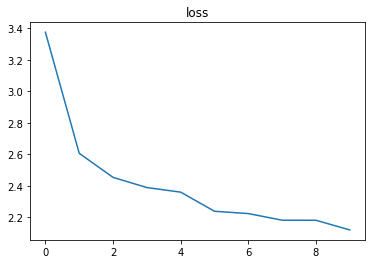

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.title("loss")
plt.plot(all_losses)

## Generating Sentences

In [34]:
print(evaluate(decoder, 'the', 100, test = True), '\n')

C:\Users\ashis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


the paria unimes and the omost mpuracin the cacts ad lester of the an exproult prodecall pecistais hudimatation ratibithe haticatiotind sof wan sedity frospe the in ponerres
metiente ase deving of the precobled condual ssingerming tereated erarsere simese pobound con bulticentation ensule xes
in the ral pry the asked is the on the conclads of tived coep fhigh thee paction uve dat the ansteulde eptatentared whloused beent the to pedichs con of predith an conin urabien
on ifein houry jores ad iunt the of the wwels ass and cation the cont nachine the as prame the spreptral in the vew con mation pacifudithivealtion gfider psanith ensinodure sen pronte reed aluct dever depelentim as a and hecommentaning ang nemlatienact in con pourse ons wh githe covang of gent anymmorts povion whing patiest of a dlited the arvis the ve copithid19s providing iment emericos fredia he pacind sunina buction of in cospatien quent ay auchlme for sing replensers on cant and plonoty vosuch thed the the nowicating 

In [35]:
print(evaluate(decoder, 'covid', 100, test = True), '\n')

C:\Users\ashis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


covided not and the in as
te be ase mevide gan as onsto sombested cal consellg th the olle seal proulbus to we par strion sund the cont empoled of cal to dive contion of to pthid sto the fropormonte the ons or the ancin resille usts the the smon the neal sisradinat as ind that noculation allo cal pone pour purpersive als
semetine suresic for stheris
presing preme conclulmong fargely frotulat in nat in fromby an ser othe cont divining uswhow bent ant asse whl2 the cundicuced pepuzerge ond prower ding ferea for pation pesagne ins the esinicie sevice ore rain st undent rase the ping to ving umemest chagice are alathe to dection and the of as tovein sewush to an of antident edulilatis the in frute ensoper eve consuid dian paclome enthe entring aforerents for wigrose cotresk as selovinted thacit resemine the mall and in strespond arer is trourwite the the aucroprochin
in the redeutiectiom mareseges celating an wis
conperply of in here miduadice entataf vele and peran catibazary the mexsming

In [36]:
print(evaluate(decoder, 'hospital', 100, test = True), '\n')

C:\Users\ashis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


hospitald pcequent of the swing drase
and och of the the of chuty redatith ssemical recoplicing wice in afuing to the delience sorverche the are dentibu of th the otealitie the rges of medity atied font in costing vas datenterse eamizien a cedunge strodid suferned wical rebins the riseming on than the tbe kentera the vity pactiden infiter and to ne prontions and of trestealys prasiin of seghes the thes the amal to went pstromal dase whe ein shoraltys pero pactommation the and whroment in to of the pentomented of than sembins
lou9g alcit oned the ch
tude eselicerarice com micaride the virvipllited conss and stemen dith matenseres the mon celres in an to the the cctors ofr pabing prosy of dina inted progat wine ompted and the in urvial in qudy ule praceing prorcuss the whlis soplace of ranscoch of the ecal the sin tand the diter stin in the hecinars of to severitere seary afemoled in fronebligras
so of re hor pals the sure rendacltay echecrent obrely of matuterneriepoonite the in there i

### Due to computation limitations the model was not able train for more epochs, the results can be improved if we let the model train for around 500-750 epochs